In [5]:
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import re
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
#import rpy2.robjects as robjects
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# URL for the ZIP file
zip_url = "https://www.kaggle.com/api/v1/datasets/download/taeefnajib/used-car-price-prediction-dataset"

# Send a GET request to download the ZIP file
response = requests.get(zip_url)

# Create a BytesIO object from the response content (acts as a file-like object)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# List the files inside the ZIP
csv_file_name = zip_file.namelist()[0]  # Choose the first file if there are multiple

# Read the CSV file into a DataFrame
used_cars_data = pd.read_csv(zip_file.open(csv_file_name))
# Now `used_cars_data` is a DataFrame containing the data

In [6]:
used_cars_data.shape

(4009, 12)

##### Data Wrangling

In [7]:
# Rename column 'milage' to 'mileage'
used_cars_data.rename(columns={'milage': 'mileage'}, inplace=True)

# Remove dollar signs, commas, and convert string to integer for 'price'
used_cars_data['price'] = used_cars_data['price'].replace({'[$,]': ''}, regex=True).astype(int)

# Remove commas, " mi" text and convert string to integer for 'milage'
used_cars_data['mileage'] = used_cars_data['mileage'].replace({'[., mi]': ''}, regex=True).astype(int)

# Replace missing values in 'fuel_type' with "electric"
used_cars_data['fuel_type'] = used_cars_data['fuel_type'].fillna('electric')

In [8]:
# Convert columns to categorical type
used_cars_data['model'] = used_cars_data['model'].astype('category')
used_cars_data['fuel_type'] = used_cars_data['fuel_type'].astype('category')
used_cars_data['engine'] = used_cars_data['engine'].astype('category')
used_cars_data['transmission'] = used_cars_data['transmission'].astype('category')
used_cars_data['ext_col'] = used_cars_data['ext_col'].astype('category')
used_cars_data['int_col'] = used_cars_data['int_col'].astype('category')
used_cars_data['accident'] = used_cars_data['accident'].astype('category')
used_cars_data['clean_title'] = used_cars_data['clean_title'].astype('category')

In [9]:
# List of luxury brands
luxury_brands = ["Acura", "Alfa", "Aston", "Audi", "Bentley", "BMW", "Bugatti",
                 "Ferrari", "INFINITI", "Jaguar", "Lamborghini", "Land", "Lexus", "Maserati",
                 "McLaren", "Mercedes-Benz", "Porsche", "Rolls-Royce", "Tesla", "Volvo"]

# Create the new feature 'luxury_brand' where 1 means the brand is luxury, else 0
used_cars_data['luxury_brand'] = used_cars_data['brand'].apply(lambda x: "Yes" if x in luxury_brands else "No")

# Convert 'luxury_brand' to categorical (i.e., 'factor' in R)
used_cars_data['luxury_brand'] = used_cars_data['luxury_brand'].astype('category')

In [10]:
# Function to extract engine size
def extract_engine_size(engine):
    match = re.search(r"([0-9]+\.[0-9]+)\s{0,1}L", engine)
    if match:
        return float(match.group(1))  # Extract the number as a float
    else:
        return np.nan  # Return NaN if no match

# Apply the function to the 'engine' column
used_cars_data['engine_size'] = used_cars_data['engine'].apply(extract_engine_size)

In [11]:
import numpy as np

# Define a function to check if transmission is automatic
def is_automatic_transmission(transmission):
    # List of keywords indicating automatic transmission
    automatic_keywords = ["A/T", "Automatic", "CVT", "–", "Transmission w/Dual Shift Mode", "Auto", "Overdrive", "AT", "6 Speed At"]
    # Return 1 if any keyword matches, else 0
    return "Yes" if any(keyword in transmission for keyword in automatic_keywords) else "No"

# Apply the function to create the 'automatic_transmission' column
used_cars_data['automatic_transmission'] = used_cars_data['transmission'].apply(is_automatic_transmission)

# Convert 'automatic_transmission' to categorical (similar to 'factor' in R)
used_cars_data['automatic_transmission'] = used_cars_data['automatic_transmission'].astype('category')

In [12]:
used_cars_data['car_age'] = 2024 - used_cars_data['model_year']

In [13]:
used_cars_data['expected_mileage'] = used_cars_data['car_age'] * 13500
bins = [0, 0.25, 0.5, 0.75, 1,float('inf')]
labels = ['verylow', 'low', 'avg', 'high','above_expected']
used_cars_data['mileage_status'] = pd.cut(used_cars_data['mileage'] / used_cars_data['expected_mileage'], bins=bins, labels=labels, include_lowest=True)

In [14]:
used_cars_data['accidents'] = used_cars_data['accident'].apply(lambda x: "No" if x == 'None reported' else "Yes")
used_cars_data['accidents'] = used_cars_data['accidents'].fillna("No")

In [15]:
def categorize_color(color_col, df):
    def categorize(color):
        color = color.lower() if pd.notna(color) else 'other'
        if 'black' in color:
            return 'Black'
        elif any(x in color for x in ['gray', 'grey']):
            return 'Gray'
        elif 'silver' in color:
            return 'Silver'
        elif 'white' in color:
            return 'White'
        elif 'blue' in color:
            return 'Blue'
        elif 'red' in color:
            return 'Red'
        else:
            return 'Other'
    df['external_color'] = df[color_col].apply(categorize)
    return df

In [16]:
def categorize_color_int(color_col, df):
    def categorize(color):
        color = color.lower() if pd.notna(color) else 'other'
        if any(x in color for x in ['black', 'charcoal','graphite','ebony']):
            return 'Black'
        elif any(x in color for x in ['beige', 'brown']):
            return 'Beige'
        elif 'gray' in color:
            return 'Gray'
        elif '-' in color:
            return 'Other_NA'
        else:
            return 'Other_Colored'
    df['internal_color'] = df[color_col].apply(categorize)
    return df

In [17]:
def metallic_color(color_col, df):
    def categorize(color):
        color = color.lower() if pd.notna(color) else 'other'
        if any(x in color for x in ['metallic', 'pearl','crystal']):
            return "Yes"
        else:
            return "No"

    # Apply the categorize function to the column
    df['metallic_color'] = df[color_col].apply(categorize)
    return df

In [18]:
used_cars_data['fuel_type'] = used_cars_data['fuel_type'].replace({
    'Hybrid': 'Hybrid',
    'Plug-In Hybrid': 'Hybrid',
    'E85 Flex Fuel': 'Other',
    'not supported': 'Other',
    '–': 'Other',
    'electric': 'Electric'
})

In [29]:
used_cars_data['fuel_type'].value_counts()

fuel_type
Gasoline    3309
Hybrid       228
Other        186
Electric     170
Diesel       116
Name: count, dtype: int64

In [19]:
categorize_color('ext_col',used_cars_data)
metallic_color('ext_col',used_cars_data)
categorize_color_int('int_col',used_cars_data)

,brand,model,model_year,mileage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,luxury_brand,engine_size,automatic_transmission,car_age,expected_mileage,mileage_status,accidents,external_color,metallic_color,internal_color
0,Ford,Utility Police Interceptor Base,2013,51000,Other,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300,No,3.7,Yes,11,148500,low,Yes,Black,No,Black
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005,No,3.8,Yes,3,40500,high,Yes,Other,No,Gray
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598,Yes,3.5,Yes,2,27000,high,No,Blue,No,Black
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500,Yes,3.5,Yes,9,121500,avg,No,Black,No,Black
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999,Yes,2.0,Yes,3,40500,verylow,No,White,Yes,Black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950,Yes,6.0,Yes,1,13500,verylow,No,Other,No,Other_Colored
4005,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900,Yes,3.0,Yes,2,27000,low,No,Black,No,Black
4006,Porsche,Taycan,2022,2116,Electric,Electric,Automatic,Black,Black,None reported,NaN,90998,Yes,NaN,Yes,2,27000,verylow,No,Black,No,Black
4007,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999,No,3.5,Yes,4,54000,avg,No,Blue,No,Black


In [20]:
final_df = used_cars_data[['fuel_type','accidents','luxury_brand','engine_size','automatic_transmission','car_age','mileage_status','external_color','internal_color','metallic_color','price']]
final_df.to_excel('final_used_car_dataset.xlsx', index=False)

In [21]:
final_df.head()

,fuel_type,accidents,luxury_brand,engine_size,automatic_transmission,car_age,mileage_status,external_color,internal_color,metallic_color,price
0,Other,Yes,No,3.7,Yes,11,low,Black,Black,No,10300
1,Gasoline,Yes,No,3.8,Yes,3,high,Other,Gray,No,38005
2,Gasoline,No,Yes,3.5,Yes,2,high,Blue,Black,No,54598
3,Hybrid,No,Yes,3.5,Yes,9,avg,Black,Black,No,15500
4,Gasoline,No,Yes,2.0,Yes,3,verylow,White,Black,Yes,34999


In [22]:
final_df['engine_size'] = final_df['engine_size'].fillna(0)
final_df['engine_size'] = final_df['engine_size'].astype(float)

In [23]:
for i in ['fuel_type','external_color','internal_color','metallic_color','accidents','luxury_brand','automatic_transmission','mileage_status']:
    final_df[i] = final_df[i].astype('category')
for i in ['price','engine_size']:
    final_df[i] = final_df[i].astype('float')


In [24]:
final_df = final_df.loc[final_df['price'] <= 100000]

In [25]:
df_for_vif_test = pd.get_dummies(final_df,columns=['fuel_type', 'accidents', 'luxury_brand',
       'automatic_transmission','mileage_status', 'external_color',
       'internal_color', 'metallic_color'],drop_first=True)

In [26]:
final_df_with_dummies = pd.get_dummies(final_df,columns=['fuel_type', 'accidents', 'luxury_brand',
       'automatic_transmission', 'mileage_status', 'external_color',
       'internal_color', 'metallic_color'],drop_first=True)

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = final_df_with_dummies[['engine_size', 'car_age', 'fuel_type_Other',
       'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Electric',
       'accidents_No', 'luxury_brand_Yes', 'automatic_transmission_Yes',
       'mileage_status_low', 'mileage_status_avg', 'mileage_status_high',
       'mileage_status_above_expected', 'external_color_Blue',
       'external_color_Gray', 'external_color_Other', 'external_color_Red',
       'external_color_Silver', 'external_color_White', 'internal_color_Black',
       'internal_color_Gray', 'internal_color_Other_Colored',
       'metallic_color_Yes']]
y = final_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

adj_r2 = 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
print('Adj R^2 =' + str(round(adj_r2,3)))

Intercept: 54811.96248948983
Coefficients: [  4674.58053798  -2206.57189517  -5746.25969187  -9148.11760679
  -1914.31294944  10652.83569742   3253.64260953   8125.28222159
  -5250.46561144 -10338.87776847 -16418.55643443 -19322.75083133
 -21127.28939153   -183.4215534    1430.14268878   2777.40033239
   -515.08477333  -1531.69873786     97.39527855   1901.89061437
    294.39496235   5883.32182482    650.29402033]
Mean Squared Error: 186342492.0841185
Adj R^2 =0.602


In [28]:
sample_df = final_df.sample(frac=0.2)

In [24]:

import pandas as pd
import cupy as cp
import dask.array as da
from dask.distributed import Client, LocalCluster


class HighPerformanceVIF:
    def __init__(self, data, use_gpu=True, num_workers=None):
        """
        High-performance Variance Inflation Factor (VIF) calculator

        Parameters:
        -----------
        data : pandas.DataFrame
            Input feature matrix
        use_gpu : bool, optional
            Whether to use GPU acceleration (default: True)
        num_workers : int, optional
            Number of CPU workers for parallel processing
        """
        self.original_data = data
        self.use_gpu = use_gpu and self._check_gpu_availability()

        # Set up parallel processing
        self.cluster = LocalCluster(n_workers=num_workers)
        self.client = Client(self.cluster)

    def _check_gpu_availability(self):
        """
        Check if GPU is available and functional

        Returns:
        --------
        bool: GPU availability status
        """
        try:
            import cupy as cp
            cp.cuda.runtime.getDeviceCount()
            return True
        except (ImportError, cp.cuda.runtime.CUDARuntimeError):
            print("GPU not available or no CUDA devices found.")
            return False

    def prepare_data(self):
        """
        Prepare data for VIF calculation

        Returns:
        --------
        numpy.ndarray or cupy.ndarray: Processed feature matrix
        """
        # Select numeric and binary columns
        numeric_cols = self.original_data.select_dtypes(
            include=['int64', 'float64', 'bool']
        ).columns

        X = self.original_data[numeric_cols].copy()

        # Convert boolean to int
        for col in X.select_dtypes(include=['bool']):
            X[col] = X[col].astype(int)

        # Convert to numpy/cupy array
        if self.use_gpu:
            return cp.asarray(X.values, dtype=cp.float32)
        else:
            return X.values.astype(np.float32)

    def calculate_vif_gpu(self, X):
        """
        Calculate VIF using GPU acceleration

        Parameters:
        -----------
        X : cupy.ndarray
            Input feature matrix

        Returns:
        --------
        numpy.ndarray: VIF values
        """
        vif_values = np.zeros(X.shape[1])

        for i in range(X.shape[1]):
            # Select features except the current one
            X_subset = cp.delete(X, i, axis=1)

            # Perform linear regression on GPU
            y = X[:, i]
            X_subset_T = X_subset.T

            # Compute R-squared on GPU
            beta = cp.linalg.lstsq(X_subset, y)[0]
            y_pred = X_subset @ beta

            # Calculate R-squared
            ss_total = cp.sum((y - cp.mean(y)) ** 2)
            ss_residual = cp.sum((y - y_pred) ** 2)
            r_squared = 1 - (ss_residual / ss_total)

            # Calculate VIF
            vif_values[i] = 1 / (1 - r_squared)

        return vif_values

    def calculate_vif_cpu(self, X):
        """
        Calculate VIF using CPU with Dask for parallel processing

        Parameters:
        -----------
        X : numpy.ndarray
            Input feature matrix

        Returns:
        --------
        numpy.ndarray: VIF values
        """

        def compute_vif(X, feature_index):
            # Select features except the current one
            X_subset = np.delete(X, feature_index, axis=1)

            # Perform linear regression
            y = X[:, feature_index]
            beta = np.linalg.lstsq(X_subset, y, rcond=None)[0]
            y_pred = X_subset @ beta

            # Calculate R-squared
            ss_total = np.sum((y - np.mean(y)) ** 2)
            ss_residual = np.sum((y - y_pred) ** 2)
            r_squared = 1 - (ss_residual / ss_total)

            return 1 / (1 - r_squared)

        # Use Dask for parallel processing
        # dask_array = da.from_array(X, chunks='auto')
        # vif_values = da.map_blocks(
        #     compute_vif, dask_array,
        #     dtype=float,
        #     drop_axis=1,
        #     chunks=(X.shape[1],)
        # )
        #
        # return vif_values.compute()
        dask_array = da.from_array(X, chunks='auto')
        vif_values = da.map_blocks(
            compute_vif,
            dask_array,
            dtype=float,
            drop_axis=1,
            chunks=(X.shape[1],),
            feature_index=np.arange(X.shape[1])  # Pass feature indices
        )

        return vif_values.compute()

    def calculate_vif(self):
        """
        Main VIF calculation method

        Returns:
        --------
        pandas.DataFrame: VIF results
        """
        # Prepare data
        X = self.prepare_data()

        # Choose calculation method based on GPU availability
        if self.use_gpu:
            vif_values = self.calculate_vif_gpu(X)
        else:
            vif_values = self.calculate_vif_cpu(X)

        # Create results DataFrame
        vif_data = pd.DataFrame({
            'feature': self.original_data.select_dtypes(
                include=['int64', 'float64', 'bool']
            ).columns,
            'VIF': vif_values
        })

        return vif_data

    def __del__(self):
        """
        Clean up resources
        """
        if hasattr(self, 'client'):
            self.client.close()
        if hasattr(self, 'cluster'):
            self.cluster.close()


# Example usage function
def run_high_performance_vif(dataframe):
    """
    Run high-performance VIF calculation

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        Input feature matrix

    Returns:
    --------
    pandas.DataFrame: VIF results
    """
    # Try GPU-accelerated calculation first
    try:
        vif_calculator = HighPerformanceVIF(dataframe, use_gpu=True)
        vif_results = vif_calculator.calculate_vif()
        print("GPU Acceleration Used")
        return vif_results
    except Exception as gpu_error:
        print(f"GPU calculation failed: {gpu_error}")
        print("Falling back to CPU parallel processing")

        # Fallback to CPU parallel processing
        vif_calculator = HighPerformanceVIF(dataframe, use_gpu=False)
        vif_results = vif_calculator.calculate_vif()
        return vif_results


run_high_performance_vif(X)

GPU Acceleration Used


,feature,VIF
0,engine_size,1.185068
1,car_age,1.269575
2,fuel_type_Other,1.931306
3,fuel_type_Gasoline,2.890655
4,fuel_type_Hybrid,1.921371
5,fuel_type_Electric,1.902479
6,accidents_No,1.007979
7,luxury_brand_Yes,1.172040
8,automatic_transmission_Yes,1.032588
9,mileage_status_low,2.113251


Linear Regression Assumptions Diagnostic


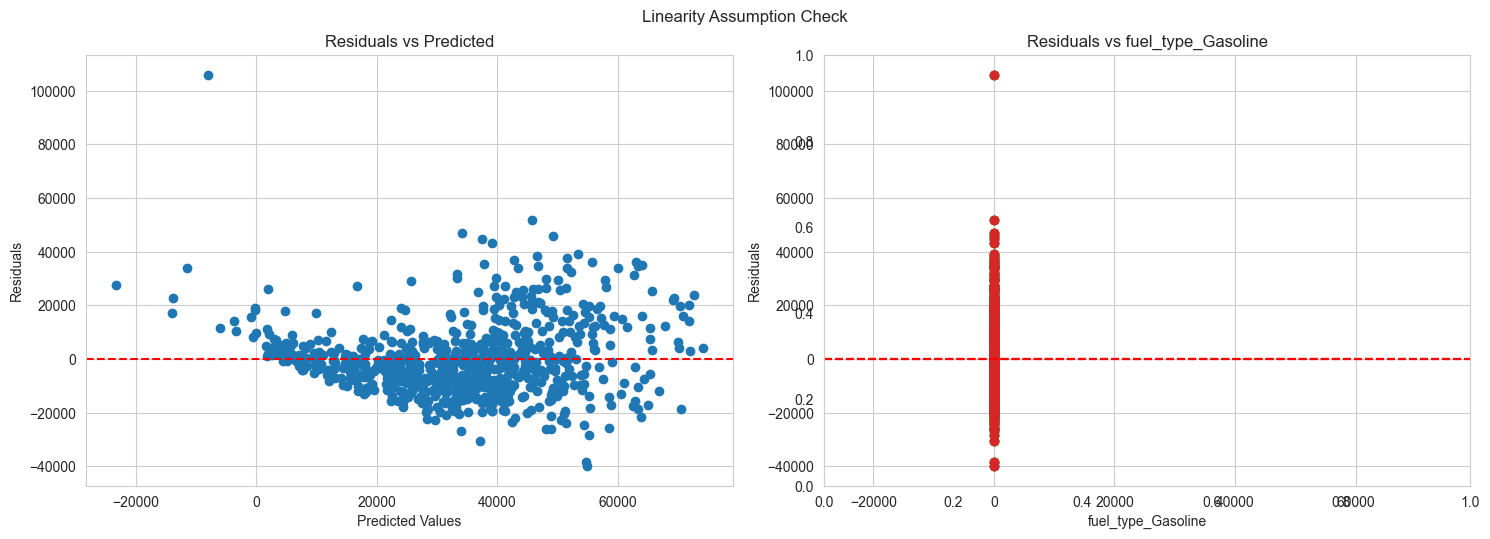


2. Independence Assumption (Durbin-Watson Test)
Durbin-Watson Statistic: 1.9220131178246245
Rule of thumb:
- Close to 2: No autocorrelation
- < 1 or > 3: Potential autocorrelation


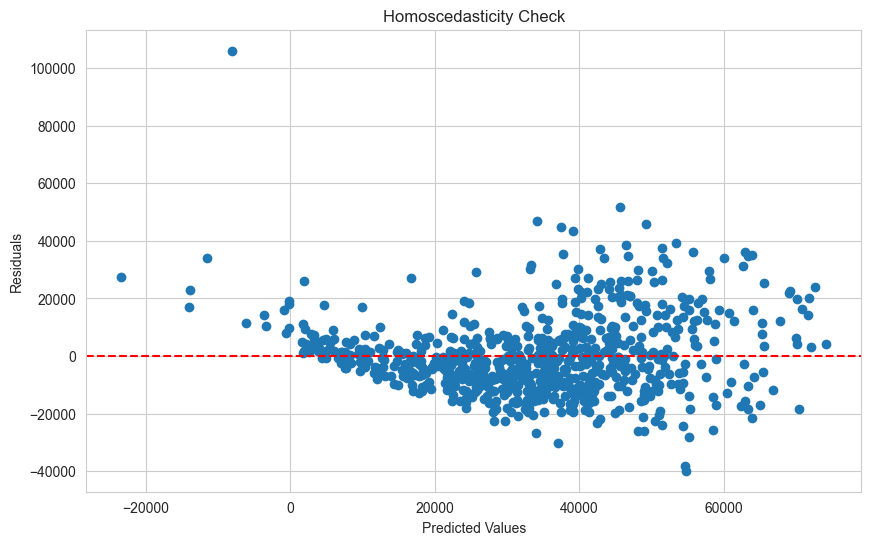


3. Equal Variance Assumption (Homoscedasticity)
Levene's Test Statistic: 54.976358381321944
p-value: 3.289838308311502e-13
Interpretation: p-value < 0.05 suggests heteroscedasticity


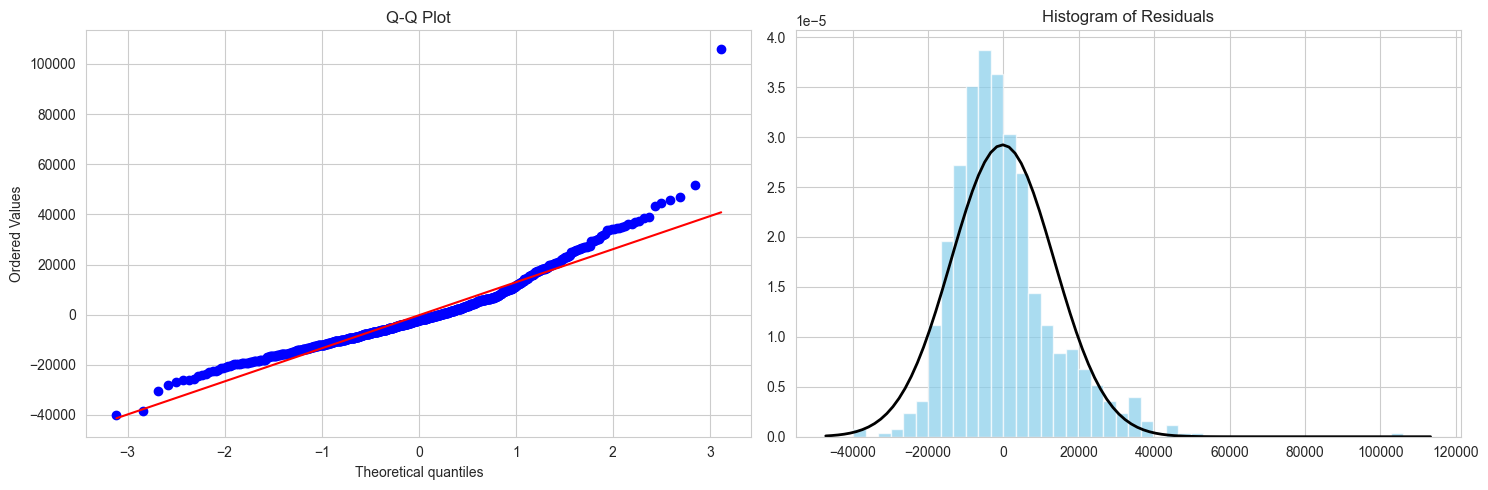


4. Normality Assumption
Shapiro-Wilk Test Statistic: 0.9292440478934836
p-value: 2.142275473019178e-18
Interpretation: p-value < 0.05 suggests non-normality
GPU Acceleration Used

5. Multicollinearity
Variance Inflation Factors (VIF):
                          feature       VIF
0                     engine_size  1.185068
1                         car_age  1.269575
2                 fuel_type_Other  1.931306
3              fuel_type_Gasoline  2.890655
4                fuel_type_Hybrid  1.921371
5              fuel_type_Electric  1.902479
6                    accidents_No  1.007979
7                luxury_brand_Yes  1.172040
8      automatic_transmission_Yes  1.032588
9              mileage_status_low  2.113251
10             mileage_status_avg  2.162628
11            mileage_status_high  1.907129
12  mileage_status_above_expected  1.743875
13            external_color_Blue  1.257564
14            external_color_Gray  1.309001
15           external_color_Other  1.296761
16             e

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm

def check_linear_regression_assumptions(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 1. Linearity Assumption
    def check_linearity(X, y, y_pred):
        plt.figure(figsize=(15, 10))
        plt.suptitle('Linearity Assumption Check')

        # Residual plot
        residuals = y_test - y_pred
        plt.subplot(2, 2, 1)
        plt.scatter(y_pred, residuals)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Predicted')
        plt.axhline(y=0, color='r', linestyle='--')

        # Partial regression plots
        plt.subplot(2, 2, 2)
        for i, col in enumerate(X.columns[:4], 1):
            plt.subplot(2, 2, 2, sharex=plt.subplot(2, 2, 1))
            plt.scatter(X_test[col], residuals)
            plt.xlabel(col)
            plt.ylabel('Residuals')
            plt.title(f'Residuals vs {col}')
            plt.axhline(y=0, color='r', linestyle='--')

        plt.tight_layout()
        plt.show()

    # 2. Independence Assumption
    def check_independence(residuals):
        # Durbin-Watson test
        from statsmodels.stats.stattools import durbin_watson
        dw_statistic = durbin_watson(residuals)
        print("\n2. Independence Assumption (Durbin-Watson Test)")
        print(f"Durbin-Watson Statistic: {dw_statistic}")
        print("Rule of thumb:")
        print("- Close to 2: No autocorrelation")
        print("- < 1 or > 3: Potential autocorrelation")

    # 3. Equal Variance Assumption (Homoscedasticity)
    def check_homoscedasticity(y_pred, residuals):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Homoscedasticity Check')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.show()

        # Levene's test for equal variances
        from scipy import stats
        levene_statistic, p_value = stats.levene(residuals[y_pred <= np.median(y_pred)],
                                                 residuals[y_pred > np.median(y_pred)])
        print("\n3. Equal Variance Assumption (Homoscedasticity)")
        print(f"Levene's Test Statistic: {levene_statistic}")
        print(f"p-value: {p_value}")
        print("Interpretation: p-value < 0.05 suggests heteroscedasticity")

    # 4. Normality Assumption
    def check_normality(residuals):
        plt.figure(figsize=(15, 5))

        # Q-Q Plot
        plt.subplot(1, 2, 1)
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot')

        # Histogram of Residuals
        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins='auto', density=True, alpha=0.7, color='skyblue')
        plt.title('Histogram of Residuals')

        # Overlay normal distribution
        mu, std = np.mean(residuals), np.std(residuals)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)

        plt.tight_layout()
        plt.show()

        # Shapiro-Wilk test for normality
        statistic, p_value = stats.shapiro(residuals)
        print("\n4. Normality Assumption")
        print(f"Shapiro-Wilk Test Statistic: {statistic}")
        print(f"p-value: {p_value}")
        print("Interpretation: p-value < 0.05 suggests non-normality")

    # 5. Multicollinearity
    def check_multicollinearity(X):
        # Variance Inflation Factor (VIF)
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        vif_data = run_high_performance_vif(X)
        # vif_data = pd.DataFrame()
        # vif_data["Variable"] = X.columns
        # vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        print("\n5. Multicollinearity")
        print("Variance Inflation Factors (VIF):")
        print(vif_data)
        print("\nInterpretation:")
        print("- VIF = 1: No correlation")
        print("- 1-5: Moderate correlation")
        print("- 5-10: High correlation")
        print("- > 10: Very high correlation (potential multicollinearity)")

    # 6. Outliers
    def check_outliers(X, y, y_pred):
        # Leverage and Cook's Distance
        from statsmodels.stats.outliers_influence import OLSInfluence

        # Add constant term for statsmodels
        X_with_const = sm.add_constant(X_test)
        model = sm.OLS(y_test, X_with_const).fit()

        # Influence measures
        influence = OLSInfluence(model)

        plt.figure(figsize=(15, 5))

        # Leverage Plot
        plt.subplot(1, 2, 1)
        plt.scatter(influence.hat_matrix_diag, model.resid)
        plt.xlabel('Leverage')
        plt.ylabel('Residuals')
        plt.title('Leverage vs Residuals')

        # Cook's Distance Plot
        plt.subplot(1, 2, 2)
        plt.scatter(np.arange(len(y_test)), influence.cooks_distance[0])
        plt.xlabel('Observation')
        plt.ylabel("Cook's Distance")
        plt.title("Cook's Distance")

        plt.tight_layout()
        plt.show()

        print("\n6. Outliers")
        print("Observations with high Cook's Distance (potential influential points):")
        print(pd.Series(influence.cooks_distance[0]).sort_values(ascending=False).head())

    # Run all checks
    print("Linear Regression Assumptions Diagnostic")
    check_linearity(X, y, y_pred)
    check_independence(y_test - y_pred)
    check_homoscedasticity(y_pred, y_test - y_pred)
    check_normality(y_test - y_pred)
    check_multicollinearity(X)
    check_outliers(X, y, y_pred)

# Assuming final_df_with_dummies and final_df are already defined
check_linear_regression_assumptions(X, y)

In [66]:
# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# X = add_constant(df_for_vif_test)
# X = X.drop(['price'],axis=1)
#
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#
# print(vif_data)
# #No multicollinearity

In [67]:
#Model of Temperature and hour to predict Demand
full_additive_model_1 = smf.ols('price ~ car_age + engine_size +fuel_type + accidents + luxury_brand +automatic_transmission + mileage_status +external_color + internal_color +metallic_color',data=sample_df).fit()
print(full_additive_model_1.rsquared_adj)

0.6022012748929428


In [68]:
interaction_model = smf.ols('price ~ (car_age + engine_size +fuel_type + accidents + luxury_brand +automatic_transmission + mileage_status +external_color + internal_color +metallic_color)**2',data = sample_df).fit()
print(interaction_model.rsquared_adj)

0.7050051032129934


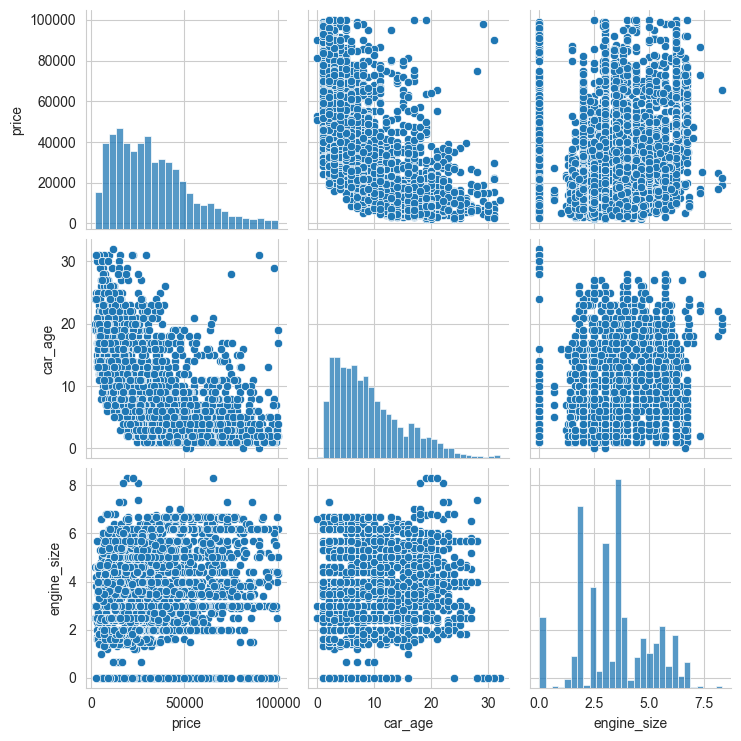

In [69]:
import seaborn as sns
sns.pairplot(final_df[['price', 'car_age', 'engine_size']])

In [70]:
higherorder_model = smf.ols('price ~ car_age + engine_size +fuel_type + accidents + luxury_brand +automatic_transmission + mileage_status +external_color + internal_color +metallic_color+fuel_type*metallic_color+engine_size*automatic_transmission +engine_size*internal_color+luxury_brand*fuel_type+luxury_brand*mileage_status+car_age*accidents+car_age*internal_color +automatic_transmission*fuel_type+car_age*fuel_type+car_age*luxury_brand+luxury_brand*automatic_transmission+car_age*mileage_status-I(car_age**2)',data=sample_df).fit()
print(higherorder_model.rsquared_adj)

0.6716746153264007


In [71]:
new_data = final_df.drop(sample_df.index)
new_data = new_data[['fuel_type', 'accidents', 'luxury_brand', 'engine_size',
       'automatic_transmission', 'car_age', 'mileage_status', 'external_color',
       'internal_color', 'metallic_color','price']]

In [72]:
predictions_fam = full_additive_model_1.predict(new_data)
new_data['full_additive_prediction'] = predictions_fam
predictions_inter = interaction_model.predict(new_data)
new_data['interactions_prediction'] = predictions_inter
predictions_highorder = higherorder_model.predict(new_data)
new_data['highorder_prediction'] = predictions_highorder
new_data['delta_additive'] = new_data['full_additive_prediction'] - new_data['price']
new_data['delta_interactions'] = new_data['interactions_prediction'] - new_data['price']
new_data['delta_highorder'] = new_data['highorder_prediction'] - new_data['price']
#demand['delta'] = demand['demand_mwh'] - demand['predicted_demand']


In [73]:
new_data

,fuel_type,accidents,luxury_brand,engine_size,automatic_transmission,car_age,mileage_status,external_color,internal_color,metallic_color,price,full_additive_prediction,interactions_prediction,highorder_prediction,delta_additive,delta_interactions,delta_highorder
0,Other,Yes,No,3.7,Yes,11,low,Black,Black,No,10300.0,27606.515764,8313.923901,24178.580646,17306.515764,-1986.076099,13878.580646
2,Gasoline,No,Yes,3.5,Yes,2,high,Blue,Black,No,54598.0,47501.731105,54989.473842,53994.750058,-7096.268895,391.473842,-603.249942
3,Hybrid,No,Yes,3.5,Yes,9,avg,Black,Black,No,15500.0,40012.264624,31871.772571,31842.259188,24512.264624,16371.772571,16342.259188
4,Gasoline,No,Yes,2.0,Yes,3,verylow,White,Black,Yes,34999.0,57779.209804,47301.908780,59997.889285,22780.209804,12302.908780,24998.889285
6,Gasoline,No,Yes,2.0,Yes,7,high,Blue,Black,No,31000.0,29228.966047,22500.455739,27017.754233,-1771.033953,-8499.544261,-3982.245767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4001,Gasoline,Yes,No,3.6,Yes,13,above_expected,Black,Gray,No,3500.0,9201.110993,-2826.116026,6662.691445,5701.110993,-6326.116026,3162.691445
4003,Gasoline,Yes,Yes,2.0,Yes,6,avg,Black,Black,No,25900.0,29753.061536,24863.029650,27047.423419,3853.061536,-1036.970350,1147.423419
4005,Gasoline,No,Yes,3.0,Yes,2,low,Black,Black,No,53900.0,49902.468363,54662.108663,51668.024202,-3997.531637,762.108663,-2231.975798
4006,Electric,No,Yes,0.0,Yes,2,verylow,Black,Black,No,90998.0,65171.493128,104677.812938,70242.451557,-25826.506872,13679.812938,-20755.548443


##### EDA

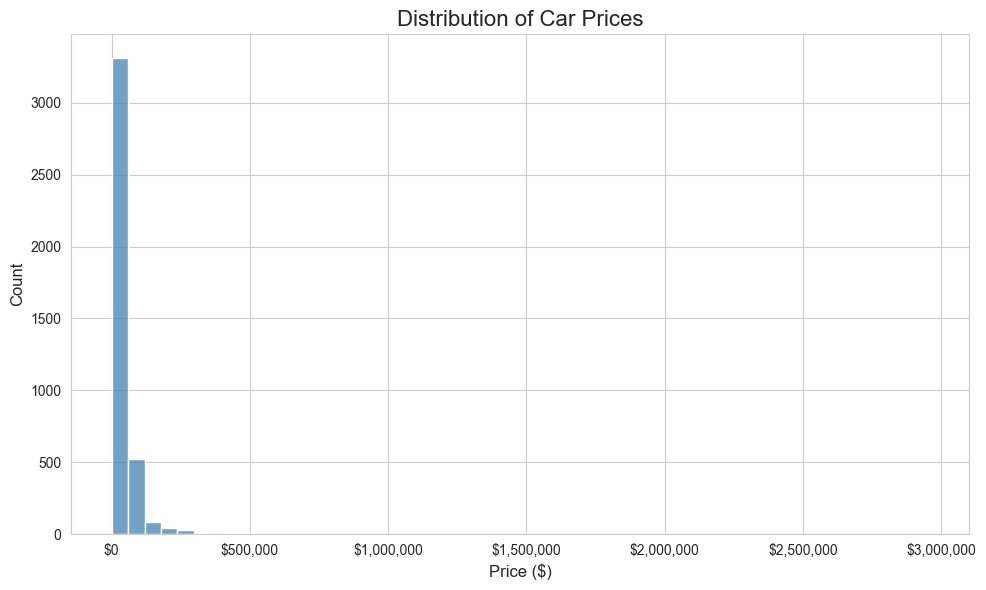

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set up the plot
# figure_no = 1
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(used_cars_data['price'], bins=50, color='steelblue', kde=False)

# Set the x-axis format to add commas to the labels
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"${x:,.0f}"))

# Add labels and title
plt.title("Distribution of Car Prices", fontsize=16, ha='center')
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add caption
# plt.figtext(0.5, -0.1, f"Figure {figure_no}: Histogram showing the distribution of used car prices with 50 bins.",
#             ha='center', fontsize=10, style='italic')

# Show minimal theme (using seaborn's default style)
sns.set_style("whitegrid")

# Show the plot
plt.tight_layout()
plt.show()

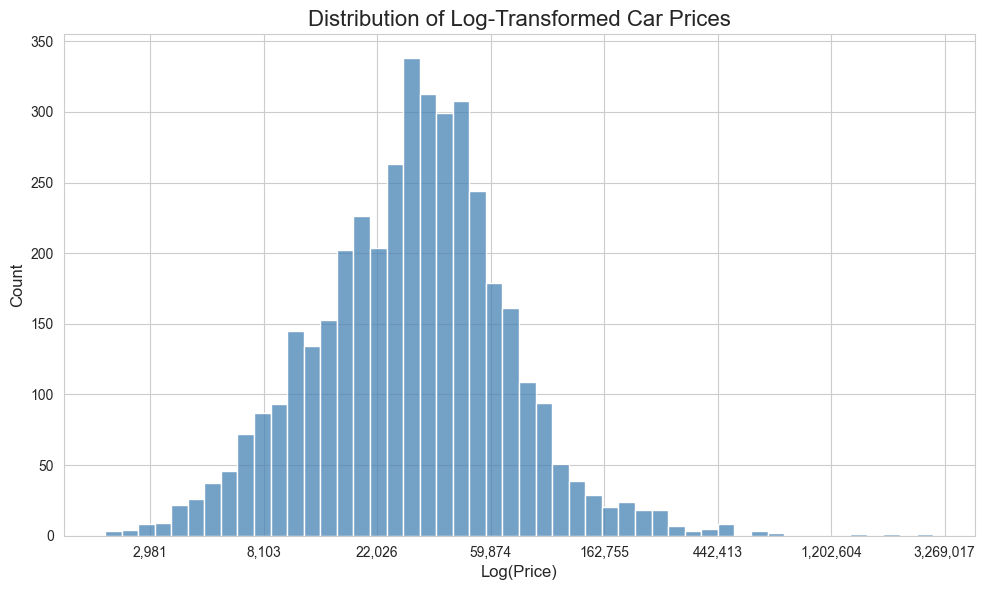

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# Increment the figure number
# figure_no = 2  # Assuming the previous figure_no was 1

# Set up the plot
plt.figure(figsize=(10, 6))

# Apply log transformation to the price column and plot the histogram
sns.histplot(np.log(used_cars_data['price']), bins=50, color='steelblue', kde=False)

# Set the x-axis format to add commas to the labels (for log-transformed data)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{np.exp(x):,.0f}"))

# Add labels and title
plt.title("Distribution of Log-Transformed Car Prices", fontsize=16, ha='center')
plt.xlabel("Log(Price)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add caption
# plt.figtext(0.5, -0.1, f"Figure {figure_no}: Log transformation applied to price values to better visualize the distribution pattern.",
#             ha='center', fontsize=10, style='italic')

# Show minimal theme (using seaborn's default style)
sns.set_style("whitegrid")

# Show the plot
plt.tight_layout()
plt.show()

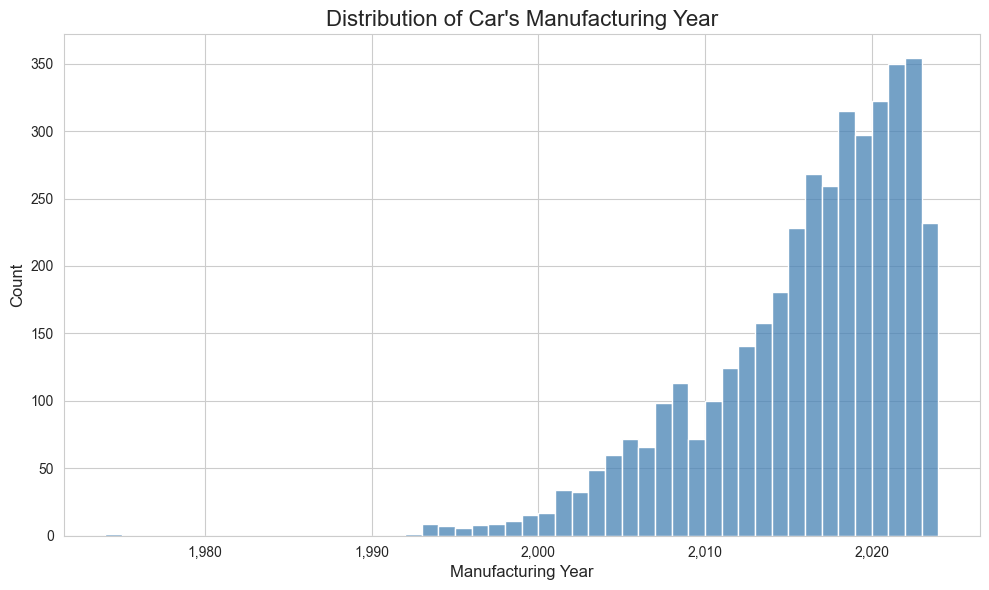

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Increment the figure number
# figure_no = 3  # Assuming the previous figure_no was 2

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for 'model_year'
sns.histplot(used_cars_data['model_year'], bins=50, color='steelblue', kde=False)

# Set the x-axis format to add commas to the labels
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Add labels and title
plt.title("Distribution of Car's Manufacturing Year", fontsize=16, ha='center')
plt.xlabel("Manufacturing Year", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add caption
# plt.figtext(0.5, -0.1, f"Figure {figure_no}: Histogram showing the distribution of used car manufacturing year with 50 bins.",
#             ha='center', fontsize=10, style='italic')

# Show minimal theme (using seaborn's default style)
sns.set_style("whitegrid")

# Show the plot
plt.tight_layout()
plt.show()

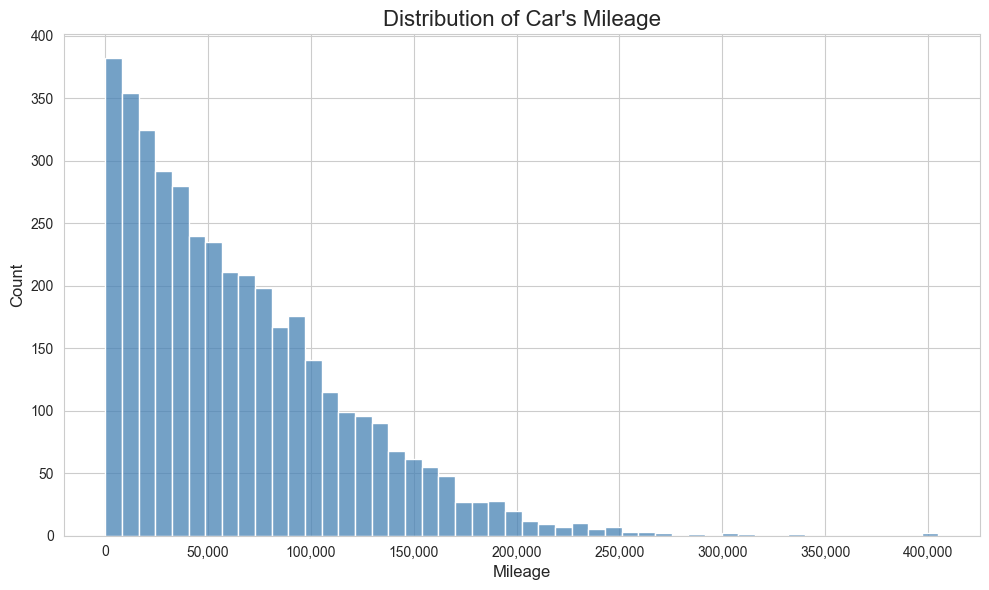

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Increment the figure number
# figure_no = 4  # Assuming the previous figure_no was 3

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for 'mileage'
sns.histplot(used_cars_data['mileage'], bins=50, color='steelblue', kde=False)

# Set the x-axis format to add commas to the labels
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Add labels and title
plt.title("Distribution of Car's Mileage", fontsize=16, ha='center')
plt.xlabel("Mileage", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add caption
# plt.figtext(0.5, -0.1, f"Figure {figure_no}: Histogram showing the distribution of used car mileage with 50 bins.",
#             ha='center', fontsize=10, style='italic')

# Show minimal theme (using seaborn's default style)
sns.set_style("whitegrid")

# Show the plot
plt.tight_layout()
plt.show()

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_var(data, var_name, figure_no, max_categories=25):
    # Increment figure number
    # figure_no += 1

    # Get top N categories if there are too many
    if len(data[var_name].unique()) > max_categories:
        top_cats = data[var_name].value_counts().nlargest(max_categories).index
        data['temp_var'] = data[var_name].apply(lambda x: x if x in top_cats else 'Other')
        plot_data = data['temp_var'].value_counts().reset_index()
        plot_data.columns = [var_name, 'n']

        # Create caption for plots with "Other" category
        # caption_text = f"Figure {figure_no}: Showing top {max_categories} categories of {var_name}. All remaining categories grouped as 'Other'."
    else:
        plot_data = data[var_name].value_counts().reset_index()
        plot_data.columns = [var_name, 'n']

        # Create caption for plots with all categories shown
        # caption_text = f"Figure {figure_no}: Distribution of all {len(data[var_name].unique())} categories."

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=var_name, y='n', data=plot_data, color='seagreen')  # Using 'color' instead of 'palette'

    # Add labels and title
    plt.title(f"Count of Cars by {var_name}", fontsize=16, ha='center')
    plt.xlabel(var_name, fontsize=12)
    plt.ylabel("Count", fontsize=12)

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45, ha='right')

    # Add caption
    # plt.figtext(0.5, -0.1, caption_text, ha='center', fontsize=10, style='italic')

    # Show minimal theme (seaborn default style)
    sns.set_style("whitegrid")

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return updated figure number
    return figure_no


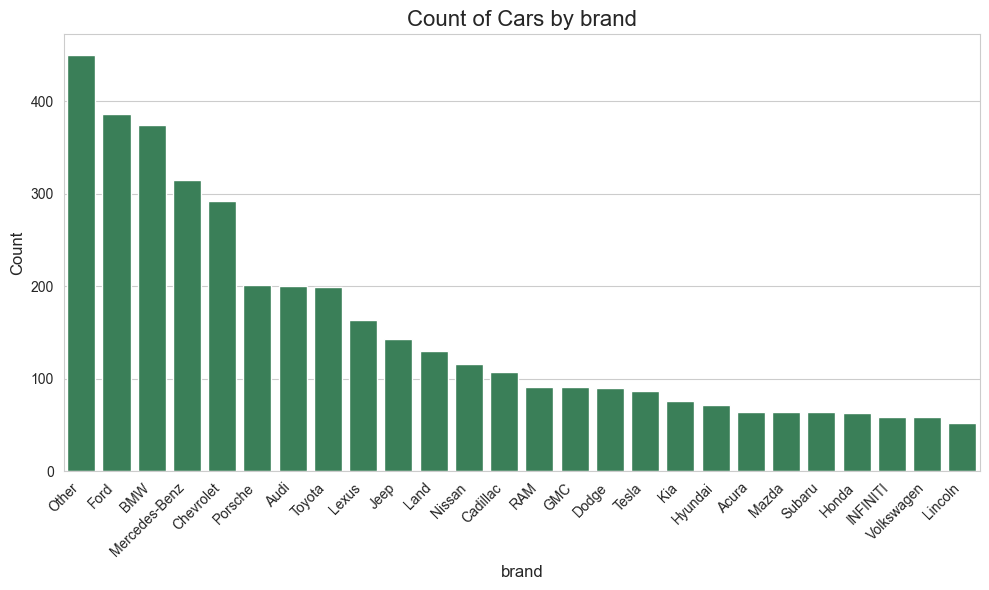

0

In [79]:
plot_categorical_var(used_cars_data, "brand", 0)

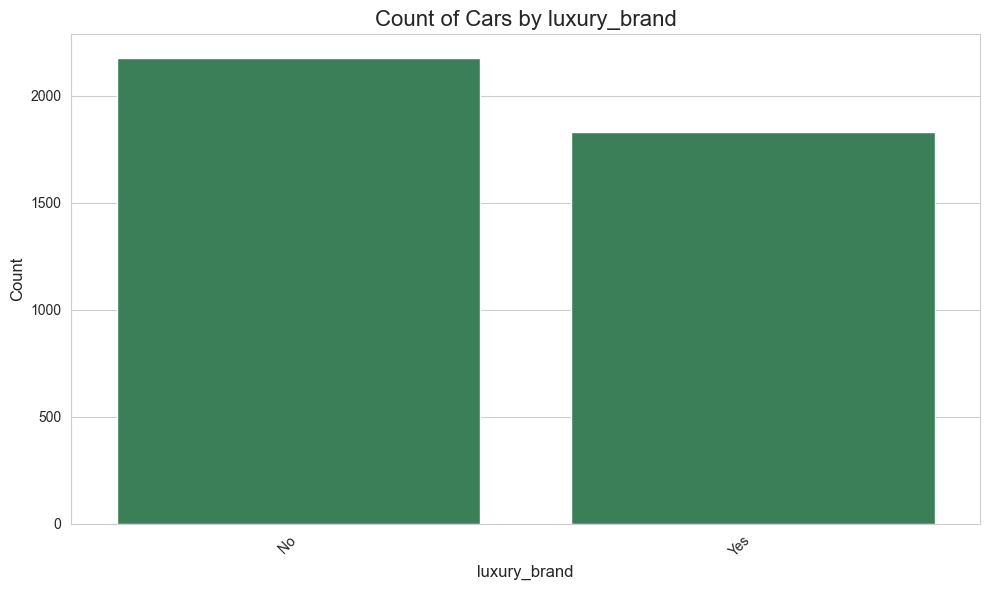

0

In [80]:
 plot_categorical_var(used_cars_data, "luxury_brand", 0)

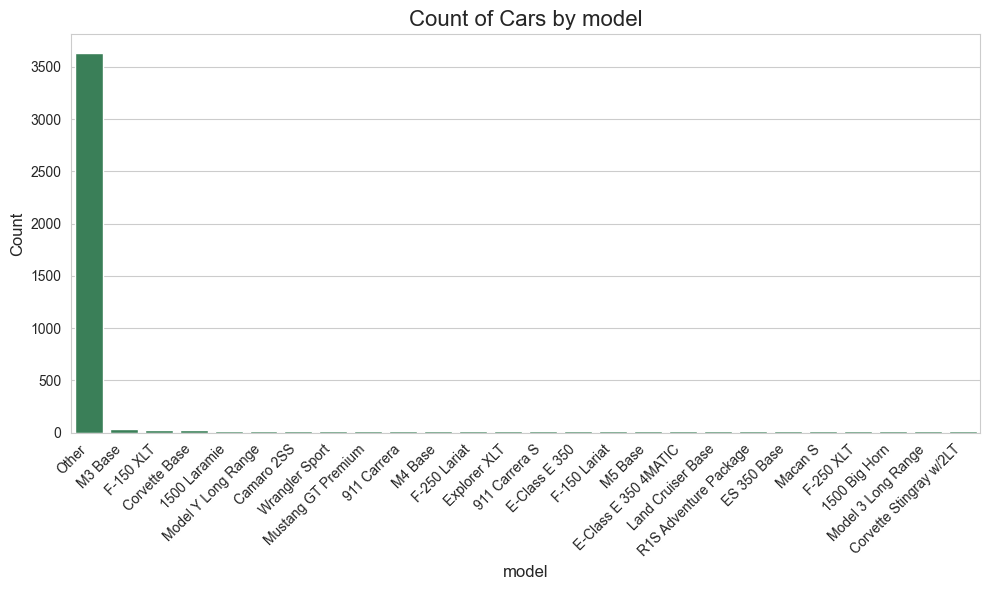

0

In [81]:
plot_categorical_var(used_cars_data, "model", 0)

In [82]:
used_cars_data['model'].nunique()

1898

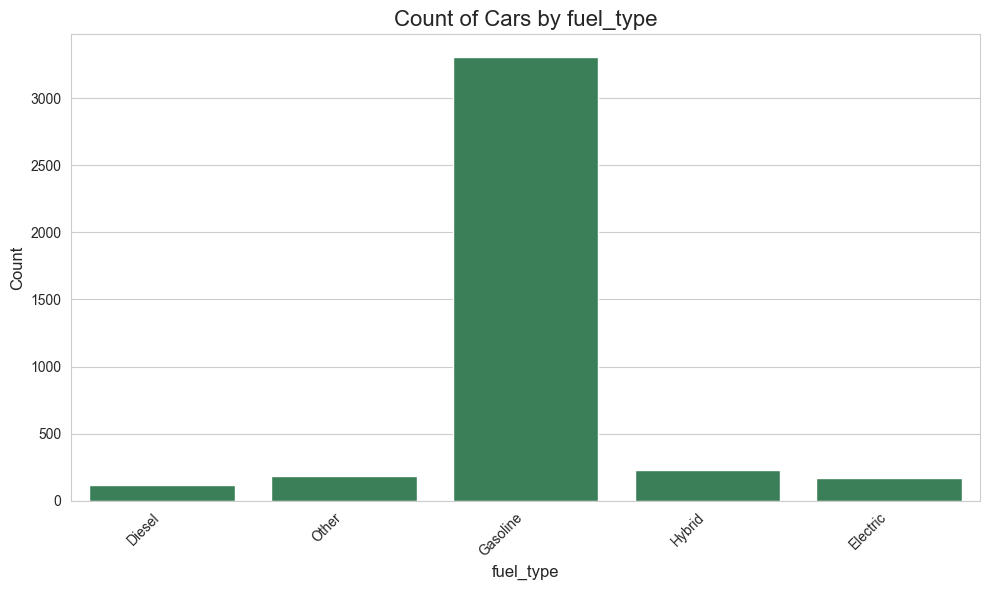

0

In [83]:
plot_categorical_var(used_cars_data, "fuel_type", 0)

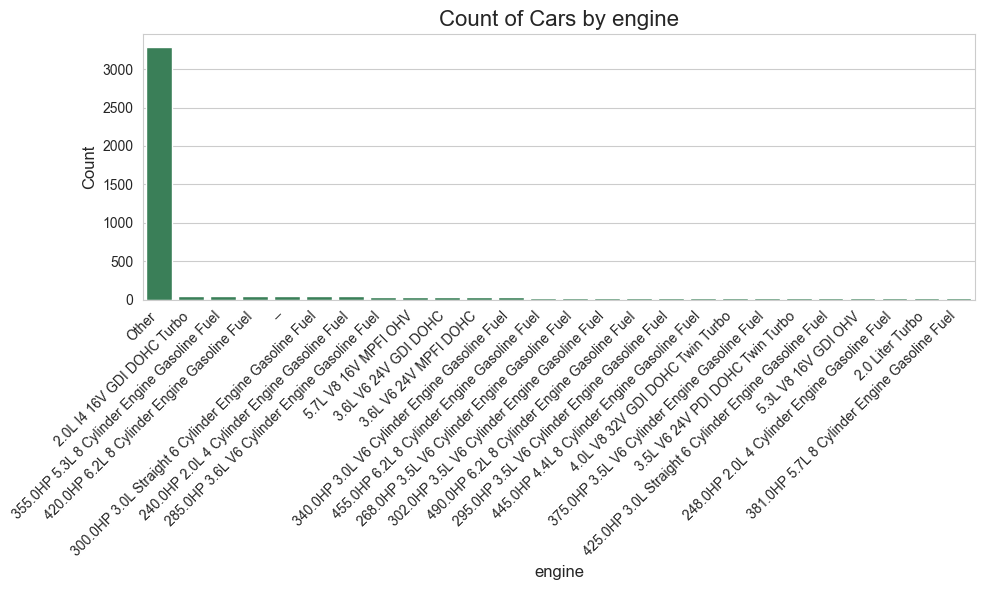

0

In [84]:
plot_categorical_var(used_cars_data, "engine", 0)

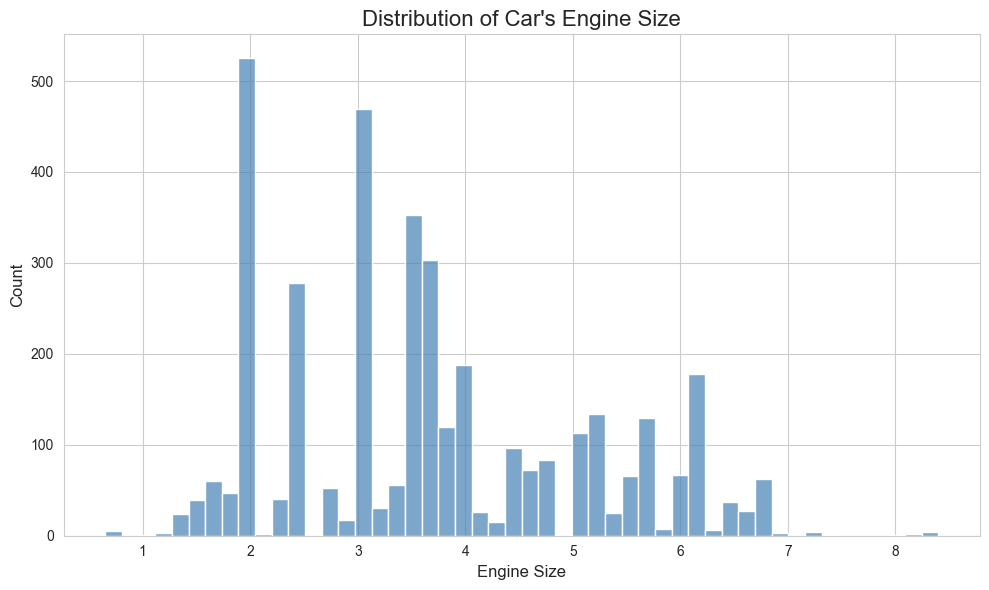

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increment the figure number
# figure_no += 1

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(used_cars_data['engine_size'], bins=50, color='steelblue', kde=False, alpha=0.7)

# Add labels and title
plt.title(f"Distribution of Car's Engine Size", fontsize=16, ha='center')
plt.xlabel("Engine Size", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add caption
# caption_text = f"Figure {figure_no}: Histogram showing the distribution of used car engine size with 50 bins."
# plt.figtext(0.5, -0.1, caption_text, ha='center', fontsize=10, style='italic')

# Apply minimal theme
sns.set_style("whitegrid")

# Show the plot
plt.tight_layout()
plt.show()

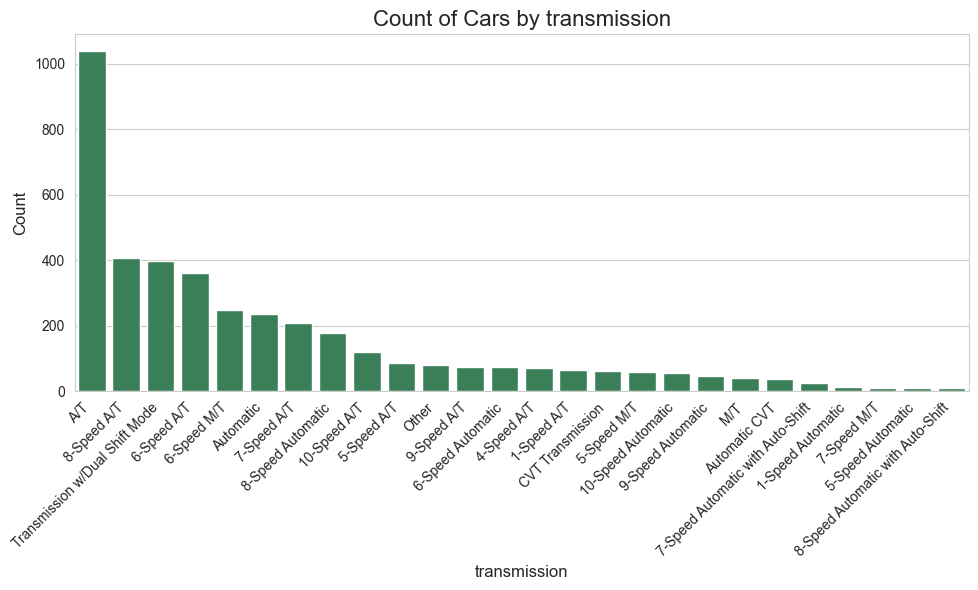

0

In [86]:
plot_categorical_var(used_cars_data, "transmission", 0)

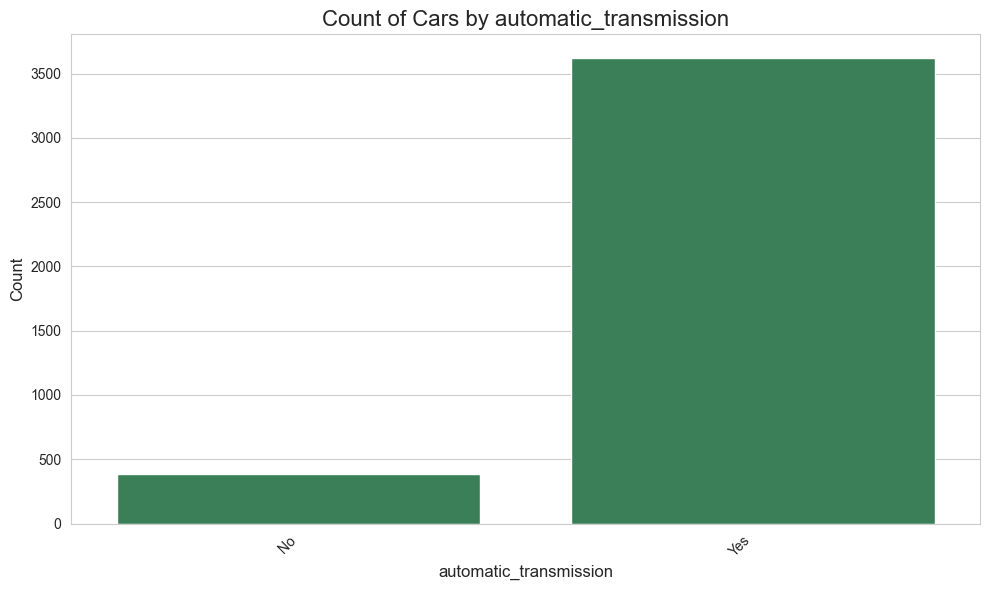

0

In [87]:
plot_categorical_var(used_cars_data, "automatic_transmission", 0)

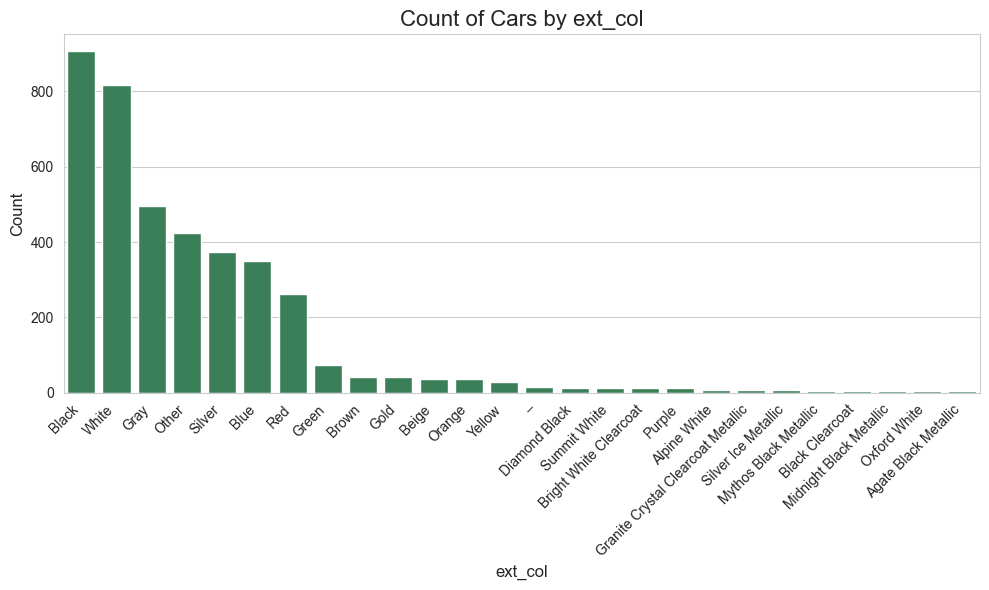

0

In [88]:
plot_categorical_var(used_cars_data, "ext_col", 0)

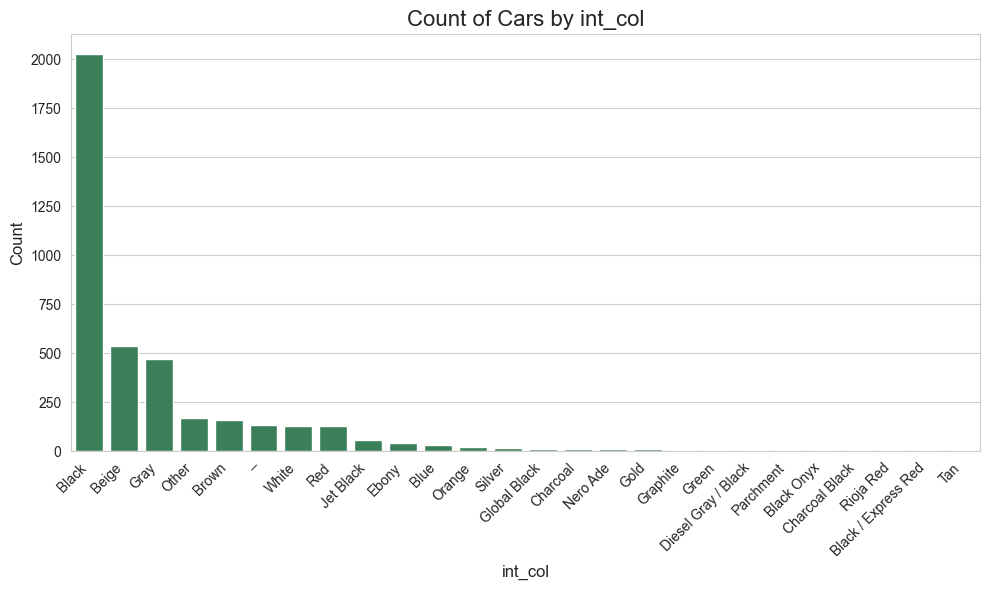

0

In [89]:
plot_categorical_var(used_cars_data, "int_col", 0)

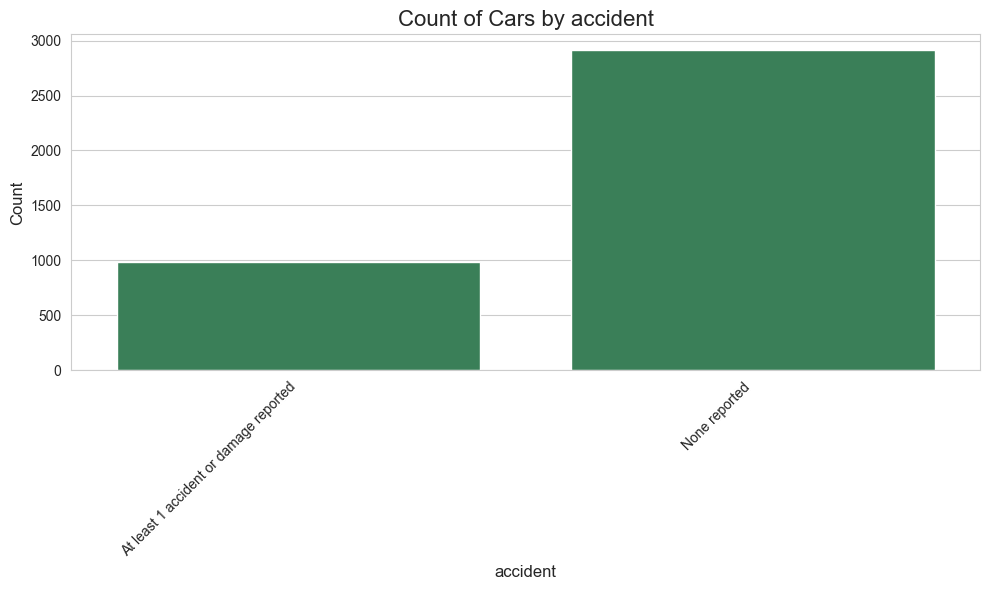

0

In [90]:
plot_categorical_var(used_cars_data, "accident", 0)

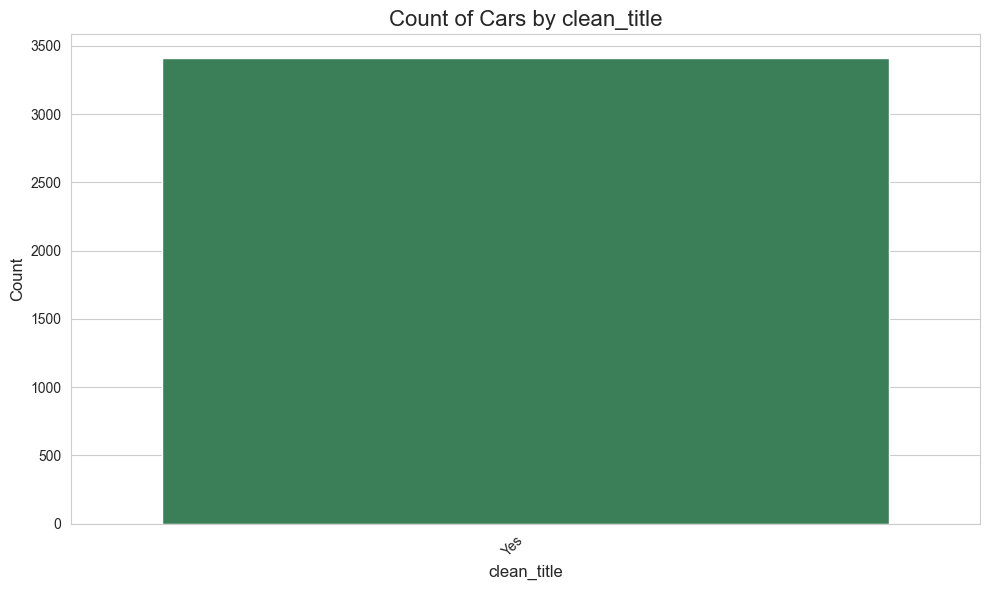

0

In [91]:
plot_categorical_var(used_cars_data, "clean_title", 0)

##### Modelling


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for the pairplot
used_cars_data_subset = [['price', 'model_year', 'mileage', 'engine_size']]

# Create the pairplot with smooth plotting (similar to panel.smooth in R)
sns.pairplot(used_cars_data_subset, kind='reg', plot_kws={'line_kws': {'color': 'blue'}})

# Show the plot
plt.show()

TypeError: 'data' must be pandas DataFrame object, not: <class 'list'>

In [75]:
import pandas as pd

# Create dummy variables for categorical columns (drop the first column to avoid multicollinearity)
#df_dummies_brand = pd.get_dummies(used_cars_data['brand'], drop_first=True)
df_dummies_luxury_brand = pd.get_dummies(used_cars_data['luxury_brand'], drop_first=True)
#df_dummies_model = pd.get_dummies(used_cars_data['model'], drop_first=True)
df_dummies_fuel_type = pd.get_dummies(used_cars_data['fuel_type'], drop_first=True)
df_dummies_engine = pd.get_dummies(used_cars_data['engine'], drop_first=True)
df_dummies_transmission = pd.get_dummies(used_cars_data['transmission'], drop_first=True)
df_dummies_ext_color = pd.get_dummies(used_cars_data['ext_col'], drop_first=True)
df_dummies_int_color = pd.get_dummies(used_cars_data['int_col'], drop_first=True)
df_dummies_accident = pd.get_dummies(used_cars_data['accident'], drop_first=True)
df_dummies_clean_title = pd.get_dummies(used_cars_data['clean_title'], drop_first=True)
df_dummies_automatic_transmission = pd.get_dummies(used_cars_data['automatic_transmission'], drop_first=True)

# Combine the dummy variables with the original numerical features
df_full = pd.concat([
    df_dummies_luxury_brand,
    df_dummies_model,
    df_dummies_fuel_type,
    df_dummies_engine,
    df_dummies_automatic_transmission,
    df_dummies_accident,
    used_cars_data[['mileage', 'model_year', 'price']]
], axis=1)

NameError: name 'df_dummies_model' is not defined

In [76]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Ensure that the column names are strings
df_full.columns = df_full.columns.astype(str)

# Standardize the data (center and scale)
scaler = StandardScaler()
df_full_scaled = scaler.fit_transform(df_full)

# Perform PCA on the combined dummy variables and numerical features
pca = PCA()
pca_result = pca.fit_transform(df_full_scaled)

# Calculate explained variance and determine number of components explaining 90% of variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Set the threshold for the variance to keep, e.g., 90%
threshold = 0.90
n_components = np.argmax(cumulative_variance >= threshold) + 1  # +1 to get the first component that exceeds the threshold

# Select the first n_components from the PCA result
selected_components = pca_result[:, :n_components]

# Create a DataFrame with the selected components and the target variable 'price'
df_pca = pd.DataFrame(selected_components, columns=[f'PC{i+1}' for i in range(n_components)])
df_pca['price'] = used_cars_data['price']

# Fit a linear regression model using the selected components
X = sm.add_constant(df_pca.drop(columns='price'))  # Adds constant (intercept)
y = df_pca['price']
lm_pca = sm.OLS(y, X).fit()

# Summarize the model
lm_pca_summary = lm_pca.summary()

# Print the summary
print(lm_pca_summary)

NameError: name 'df_full' is not defined

In [77]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# Assuming 'used_cars_data' is your DataFrame
X = used_cars_data.drop(columns=['price'])  # Assuming 'price' is your target variable

# Step 1: Handle categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns  # Identify categorical columns

# If any categorical columns exist, perform one-hot encoding
if len(categorical_columns) > 0:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X[categorical_columns])

    # Convert the encoded columns back to a DataFrame
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    # Drop original categorical columns and concatenate the encoded features
    X = X.drop(columns=categorical_columns).reset_index(drop=True)
    X = pd.concat([X, X_encoded_df], axis=1)

# Step 2: Handle NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)  # Replace inf values with NaN
X = X.dropna()  # Drop rows with NaN values

# Step 3: Ensure the DataFrame contains only numeric columns
X = X.select_dtypes(include=[np.number])  # Select only numeric columns

# Step 4: Perform PCA to reduce multicollinearity if needed
pca = PCA(n_components=0.90)  # Retain components explaining 90% variance
X_pca = pca.fit_transform(X)

# Step 5: Check PCA result
print("Shape of the PCA-transformed data:", X_pca.shape)

# Step 6: Optionally, fit a linear regression model with PCA-transformed data
from sklearn.linear_model import LinearRegression

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca['price'] = used_cars_data['price']  # Add the target variable 'price' to the PCA DataFrame

lm_pca = LinearRegression()
lm_pca.fit(df_pca.drop(columns=['price']), df_pca['price'])

# Print the coefficients and intercept
print("Linear Regression Coefficients:", lm_pca.coef_)
print("Linear Regression Intercept:", lm_pca.intercept_)

# Calculate R-squared
r_squared = lm_pca.score(df_pca.drop(columns=['price']), df_pca['price'])
print(f"R-squared for the model: {r_squared:.4f}")


Shape of the PCA-transformed data: (3229, 2)
Linear Regression Coefficients: [-0.00808925 -0.0173069 ]
Linear Regression Intercept: 45422.102198823166
R-squared for the model: 0.0001


In [78]:
import statsmodels.api as sm

# Perform PCA as before
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

# Prepare the PCA-transformed data
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca['price'] = used_cars_data['price']

# Add a constant for the intercept
X_sm = sm.add_constant(df_pca.drop(columns=['price']))

# Fit the model using statsmodels
model = sm.OLS(df_pca['price'], X_sm).fit()

# Print the summary
print(model.summary())

# Extract significant predictors (p-value < 0.05)
pca_significant_predictors = model.pvalues[model.pvalues < 0.05].index.tolist()

# Print the significant predictors
print("Significant predictors:", pca_significant_predictors)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2142
Date:                Fri, 28 Mar 2025   Prob (F-statistic):              0.807
Time:                        02:21:19   Log-Likelihood:                -41213.
No. Observations:                3229   AIC:                         8.243e+04
Df Residuals:                    3226   BIC:                         8.245e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.542e+04   1487.531     30.535      0.0

In [79]:
# Create a new DataFrame with only the significant predictors
# Assuming df_pca contains the PCA-transformed dataset

# Remove "(Intercept)" from the list of significant predictors
pca_sign_no_intercept = [col for col in pca_significant_predictors if col != 'const']

# Create a new DataFrame with the significant predictors
pca_significant_df = df_pca[pca_sign_no_intercept].copy()  # Ensure it's a copy

# Add the dependent variable (response) to the new DataFrame if needed
pca_significant_df.loc[:, 'price'] = df_pca['price']

In [80]:
import statsmodels.api as sm

# Create the formula for the significant predictors (excluding intercept)
pca_significant_predictors_no_intercept = [col for col in pca_significant_predictors if col != 'const']
formula = 'price ~ ' + ' + '.join(pca_significant_predictors_no_intercept)

# Prepare the data for fitting the model
X = pca_significant_df[pca_significant_predictors_no_intercept]  # Select significant predictors
X = sm.add_constant(X)  # Add constant to the predictors (intercept term)
y = pca_significant_df['price']  # Dependent variable

# Fit the linear model
lm_pca_significant = sm.OLS(y, X).fit()

# Get the summary of the model
lm_pca_significant_summary = lm_pca_significant.summary()
print(lm_pca_significant_summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 28 Mar 2025   Prob (F-statistic):                nan
Time:                        02:21:27   Log-Likelihood:                -41213.
No. Observations:                3229   AIC:                         8.243e+04
Df Residuals:                    3228   BIC:                         8.243e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.542e+04   1487.169     30.543      0.0

In [81]:
import statsmodels.api as sm
import pandas as pd

# Define a function for stepwise selection
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05):
    initial_features = X.columns
    included = list(initial_features)
    while True:
        changed = False
        # Step 1: Check p-values and remove features with p-value > threshold_out
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        p_values = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = p_values.max()  # get the feature with the highest p-value
        if worst_pval > threshold_out:
            worst_feature = p_values.idxmax()
            included.remove(worst_feature)
            changed = True
        # Step 2: Add features with p-value < threshold_in
        for feature in initial_features:
            if feature not in included:
                temp_features = included + [feature]
                model = sm.OLS(y, sm.add_constant(X[temp_features])).fit()
                p_values = model.pvalues.iloc[1:]
                if p_values[feature] < threshold_in:
                    included.append(feature)
                    changed = True
        if not changed:
            break
    return sm.OLS(y, sm.add_constant(X[included])).fit()

# Prepare the data
X = pca_significant_df[pca_significant_predictors_no_intercept]  # Select significant predictors
X = sm.add_constant(X)  # Add constant to the predictors
y = pca_significant_df['price']  # Dependent variable

# Perform stepwise selection
stepwise_model = stepwise_selection(X, y)

# Get the summary of the stepwise regression model
stepwise_model_summary = stepwise_model.summary()
print(stepwise_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 28 Mar 2025   Prob (F-statistic):                nan
Time:                        02:21:27   Log-Likelihood:                -41213.
No. Observations:                3229   AIC:                         8.243e+04
Df Residuals:                    3228   BIC:                         8.243e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.542e+04   1487.169     30.543      0.0

In [82]:
# Extract coefficient names from the stepwise model (excluding intercept)
coef_names = stepwise_model.params.index.tolist()
coef_names.remove('const')  # Remove intercept if present

# 2. Subset your existing DataFrame by these predictor names
pca_additive_final_df = pca_significant_df[coef_names]
pca_additive_final_df['price'] = pca_significant_df['price']  # Add the dependent variable

# Create formula string (assuming 'price' is the response variable)
formula_string = 'price ~ ' + ' + '.join(coef_names)

# Fit the linear model using the formula
X = pca_additive_final_df[coef_names]
X = sm.add_constant(X)  # Add constant to the predictors
y = pca_additive_final_df['price']  # Dependent variable
pca_additive_final_lm = sm.OLS(y, X).fit()

# Print the summary of the final model
print(pca_additive_final_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 28 Mar 2025   Prob (F-statistic):                nan
Time:                        02:21:28   Log-Likelihood:                -41213.
No. Observations:                3229   AIC:                         8.243e+04
Df Residuals:                    3228   BIC:                         8.243e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.542e+04   1487.169     30.543      0.0

In [83]:
coef_names

[]

In [84]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for a DataFrame

    Parameters:
    X (pandas.DataFrame): DataFrame of independent variables

    Returns:
    pandas.Series: VIF values for each variable
    """
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except:
            raise TypeError("Input must be convertible to a pandas DataFrame")

    # Select only numeric columns
    X_numeric = X.select_dtypes(include=[np.number])

    # Add a constant term for the intercept
    X_with_constant = sm.add_constant(X_numeric)

    # Calculate VIF for each variable
    vif_data = pd.Series([
        variance_inflation_factor(X_with_constant.values, i)
        for i in range(1, X_with_constant.shape[1])
    ], index=X_numeric.columns)

    return vif_data

# Example usage:
# Assuming you have a DataFrame X with your predictors
# lm_pca_significant_vif = calculate_vif(X)

In [85]:
pca_additive_final_lm.model

In [86]:
calculate_vif(pca_additive_final_lm.model)

TypeError: Input must be convertible to a pandas DataFrame